Moana Aulagner, Maxence Brault, Siegfried Dubois - M2 BIOINFORMATIQUE

# BIRD-ID : Deep-learning pour la classification de chants d'oiseaux

## Introduction

Ce court notebook se veut comme une présentation rapide du contenu du projet, et des features principales du projet.
Il présente le pipeline qu'un `toy_example` a à suivre afin d'être exploitable, puis de créer un modèle, puis de l'exécuter.
Un modèle d'exemple léger, mais entraîné sur plus de données que ce que ce notebook vous proposera de faire, est enregistré dans le dossier `models_samples`, et sera chargé pour les dernières étapes ; bien que l'on puisse totalement utiliser le modèle que l'on produit au cours de ce notebook.

Les modèles développés au cours de ce projet ont été entraînés à base d'une application de ce pipeline aux données issues de [cette issue Kaggle](https://www.kaggle.com/c/birdsong-recognition/overview). Les données ont été sélectionnées selon la table `rating.json` fournie (basée sur le score annoté à chaque audio), et toutes été converties par transformée de Fourier en spectrogrammes, donnés en data d'entraînement pour le modèle.

La solution qui va être présentée dans ce notebook repose sur l'usage d'un unique CNN, bien qu'une architecture ResNet soit également implémentée et que des méthodes d'ensemble soient envisageables sans changement majeur dans le code (modifier l'architecture du `main.py` serait la seule action à effectuer, et est envisagée pour une poursuite du projet hors du cadre du rendu).

Pour des informations plus détaillées ainsi que les fonctionnalités non développées au fil de ce rapport, il est possible de se référer aux `docstrings` des fonctions qui décrivent leur comportement, paramètres et retours.
Le module `lib` contient les classes `audio_sampling.py`, `metadata_extract.py` et `tensorflow_model.py` qui regroupent la majorité des fonctions nécessaires à l'exécution du progamme.
Deux scipts annexes, `plot_metric.py` et `sampler.py` se trouvent dans le dossier `dev`.
Enfin, les classes `main.py` et `constants.py` contiennent respectivement la boucle d'exécution liant toutes les fonctions, et les constantes nécessaires à l'exécution de cette boucle.

## Présentation du pipeline

Import des fonctions définies dans le module `lib` (contient les fonctions pour le processing de l'audio et la création de modèles)

In [1]:
from lib import audio_processing, modeling, prediction, save_model, load_model

Import de quelques modules complémentaires afin de visualiser les résultats et les modèles

In [3]:
from json import load
from os import listdir,system
from pathlib import Path
from numpy import asarray, std, mean
import matplotlib.pyplot as plt
from IPython.display import Image, display

Pour effectuer des prédictions, on va avoir besoin de générer des spectrogrammes depuis les fichiers audio, car les modèles sont entraînés grâce à ce type de données. Techniquement, on fait appel à la fonction `audio_processing` pour cela. On est ici sur un petit exemple, on va donc ne pas utiliser le multiprocessing, en revanche l'appel à cette fonction par le `main` le prend en charge.

In [3]:
audio_folder:str = "toy_data"
output:str = "toy_train"

for specie in listdir(audio_folder):
    Path(f"{output}/{specie}").mkdir(parents=True, exist_ok=True)
    audio_processing(audio_folder,output,specie)

CRITICAL:root:Processing specie 'blujay'
C:\Users\Tharos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\Tharos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
CRITICAL:root:Processing specie 'bushti'
CRITICAL:root:Processing specie 'cacwre'
CRITICAL:root:Processing specie 'comyel'
CRITICAL:root:Processing specie 'haiwoo'


Afin de créer un modèle, on doit définir un certain nombre de paramètres, notamment d'architecture. Sont listés ici les paramètres d'un modèle présenté lors de la présentation orale, nommé 'modèle à 6 couches'.

In [3]:
HEIGHT: int = 500  # nb de pixels en hauteur
WIDTH: int = 400  # nb de pixels en largeur

MODEL_PARAMS: dict = {
    'model_name': 'model_02',
    'epochs': 100,
    'early_stopping': True,
    'batch': 256,
    'validation_split': 0.2,
    'layer_01_filter_count': 8,
    'layer_02_filter_count': 8,
    'layer_03_filter_count': 16,
    'layer_04_filter_count': 32,
    'layer_05_filter_count': 32,
    'layer_06_filter_count': 16,
    'layer_01_kernel_size': 5,
    'layer_02_kernel_size': 3,
    'layer_03_kernel_size': 3,
    'layer_04_kernel_size': 3,
    'layer_05_kernel_size': 3,
    'layer_06_kernel_size': 3,
    'layer_dense_size': 64,
    'dropout': 0.2,
    'num_layers': 6,
    'l1_regularization': 0.0,
    'l2_regularization': 0.01
}

On va maintenant pouvoir entraîner le modèle sur nos données que l'on vient de produire.

In [6]:
modeling(output,HEIGHT,WIDTH,MODEL_PARAMS,True,False,save_path="models_samples")

Found 679 files belonging to 5 classes.
Using 544 files for training.
Found 679 files belonging to 5 classes.
Using 135 files for validation.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 500, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 400, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 200, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 200, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 100, 8)      0         
 2D)                                          

C:\Users\Tharos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 41s 11s/step - loss: 2.7299 - accuracy: 0.3566 - val_loss: 2.5037 - val_accuracy: 0.4815
Epoch 2/100
3/3 [==============================] - 40s 11s/step - loss: 2.5413 - accuracy: 0.4393 - val_loss: 2.3799 - val_accuracy: 0.4815
Epoch 3/100
3/3 [==============================] - 40s 11s/step - loss: 2.4138 - accuracy: 0.4393 - val_loss: 2.3044 - val_accuracy: 0.4815
Epoch 4/100
3/3 [==============================] - 40s 11s/step - loss: 2.3285 - accuracy: 0.4393 - val_loss: 2.1867 - val_accuracy: 0.4815
Epoch 5/100
3/3 [==============================] - 40s 11s/step - loss: 2.2124 - accuracy: 0.4393 - val_loss: 2.0678 - val_accuracy: 0.4815
Epoch 6/100
3/3 [==============================] - 40s 11s/step - loss: 2.0804 - accuracy: 0.4504 - val_loss: 1.9058 - val_accuracy: 0.6000
Epoch 7/100
3/3 [==============================] - 40s 11s/step - loss: 1.9357 - accuracy: 0.5276 - val_loss: 1.7402 - val_accuracy: 0.6444
Epoch 8/100
3/3 [===============

Le modèle est enregistré dans le dossier `models_samples`, et on peut y retrouver les graphes présentant les résultats sur le jeu de validation, ainsi que l'évolution des métriques en fonction des epochs. On peut également générer nos propores graphes afin de comparer des modèles avec les informations sauvegardées dans les fichiers .json.

In [22]:
import matplotlib
matplotlib.use('TkAgg')

NOMS = ["Modèle fourni", "Modèle réduit"]
PREFIXES: list = ["model_01", "model_02"]

# on met le nom de la métrique que l'on veut récup (key du dictionnaire json)
METRIC: str = 'true_epochs'
EPOCH_BOUND: int = 30

metric: list = [[] for _ in range(len(PREFIXES))]

# on donne le dir des modèles
PATH: str = "models_samples"


def match(dir: str, prefixes: list) -> bool:
    for elt in prefixes:
        if elt in dir:
            return True
    return False


def get_prefix(dir: str, prefixes: str) -> str:
    for elt in prefixes:
        if elt in dir:
            return elt


is_metric_list: bool = False
x = [i for i in range(EPOCH_BOUND)]
plt.rcParams["figure.figsize"] = (6, 8)
for dir in [d for d in listdir(f"{PATH}/") if match(d, PREFIXES)]:
    dic_params: dict = load(open(f"{PATH}/{dir}/params.json", "r"))
    if isinstance(dic_params[METRIC], list):
        is_metric_list = True
        metric[PREFIXES.index(get_prefix(dir, PREFIXES))
               ].append(dic_params[METRIC][:EPOCH_BOUND])
    else:
        metric[PREFIXES.index(get_prefix(dir, PREFIXES))
               ].append(dic_params[METRIC])

if is_metric_list:
    for i, met in enumerate(metric):
        plt.errorbar(x, [mean(serie) for serie in asarray(
            met).transpose()], yerr=[std(serie)/2 for serie in asarray(
                met).transpose()], label=NOMS[i], fmt='--o')
    plt.legend()
    plt.show()
else:
    error = [std(serie)/2 for serie in asarray(metric)]
    for i, val in enumerate([mean(serie) for serie in asarray(metric)]):
        plt.bar(i, val, yerr=error[i], label=NOMS[i],
                align='center', alpha=0.5, ecolor='black', capsize=10)
    plt.xticks([i for i in range(len(PREFIXES))], NOMS)
    plt.show()

Des modèles légers d'exemple (entraînés sur 5 espèces) ont été sauvegardés dans le dossier `models_samples`. On va charger un de ces modèles.

In [4]:
model_path:str = "models_samples/model_01"

trained_model,classes = load_model(model_path)

On peut voir les informations d'entraînement du modèle ainsi que les paramètres ayant servi à l'entraîner, sauvegardées dans un fichier .json

In [5]:
load(open(f"{model_path}/params.json", "r"))

{'execution_time': 5623.843999999983,
 'cpu_time': 17019.21875,
 'true_epochs': 36,
 'accuracy_train': [0.25949999690055847,
  0.3269999921321869,
  0.4620000123977661,
  0.6520000100135803,
  0.7204999923706055,
  0.7639999985694885,
  0.8065000176429749,
  0.8379999995231628,
  0.8450000286102295,
  0.8514999747276306,
  0.8730000257492065,
  0.8784999847412109,
  0.8774999976158142,
  0.8880000114440918,
  0.9054999947547913,
  0.9014999866485596,
  0.9144999980926514,
  0.9200000166893005,
  0.9350000023841858,
  0.9434999823570251,
  0.949999988079071,
  0.953000009059906,
  0.949999988079071,
  0.9509999752044678,
  0.9459999799728394,
  0.9629999995231628,
  0.9649999737739563,
  0.9714999794960022,
  0.9729999899864197,
  0.9660000205039978,
  0.9750000238418579,
  0.9804999828338623,
  0.984499990940094,
  0.9810000061988831,
  0.9714999794960022,
  0.9785000085830688],
 'loss_train': [1.6012455224990845,
  1.5556195974349976,
  1.3614341020584106,
  0.9710457921028137,
  0.76

On peut également récupérer les informations de structure du modèle, sauvegardées dans un fichier texte

In [6]:
''.join(l for l in open(f"{model_path}/model.txt"))

'Model: "sequential_17"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n rescaling_17 (Rescaling)    (None, 500, 400, 3)       0         \n                                                                 \n conv2d_84 (Conv2D)          (None, 500, 400, 8)       608       \n                                                                 \n max_pooling2d_84 (MaxPoolin  (None, 250, 200, 8)      0         \n g2D)                                                            \n                                                                 \n conv2d_85 (Conv2D)          (None, 250, 200, 8)       584       \n                                                                 \n max_pooling2d_85 (MaxPoolin  (None, 125, 100, 8)      0         \n g2D)                                                            \n                                     

... ainsi qu'obsterver les résulats des graphes sauvegardés

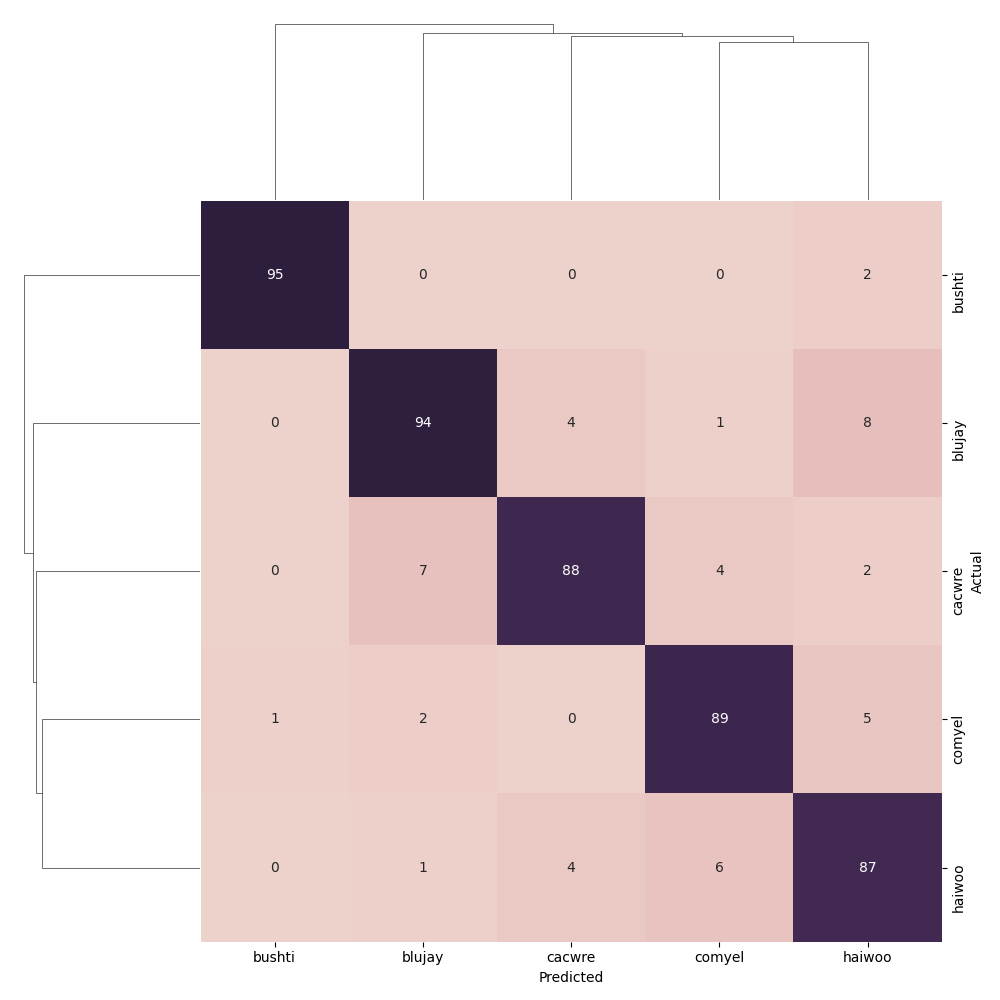

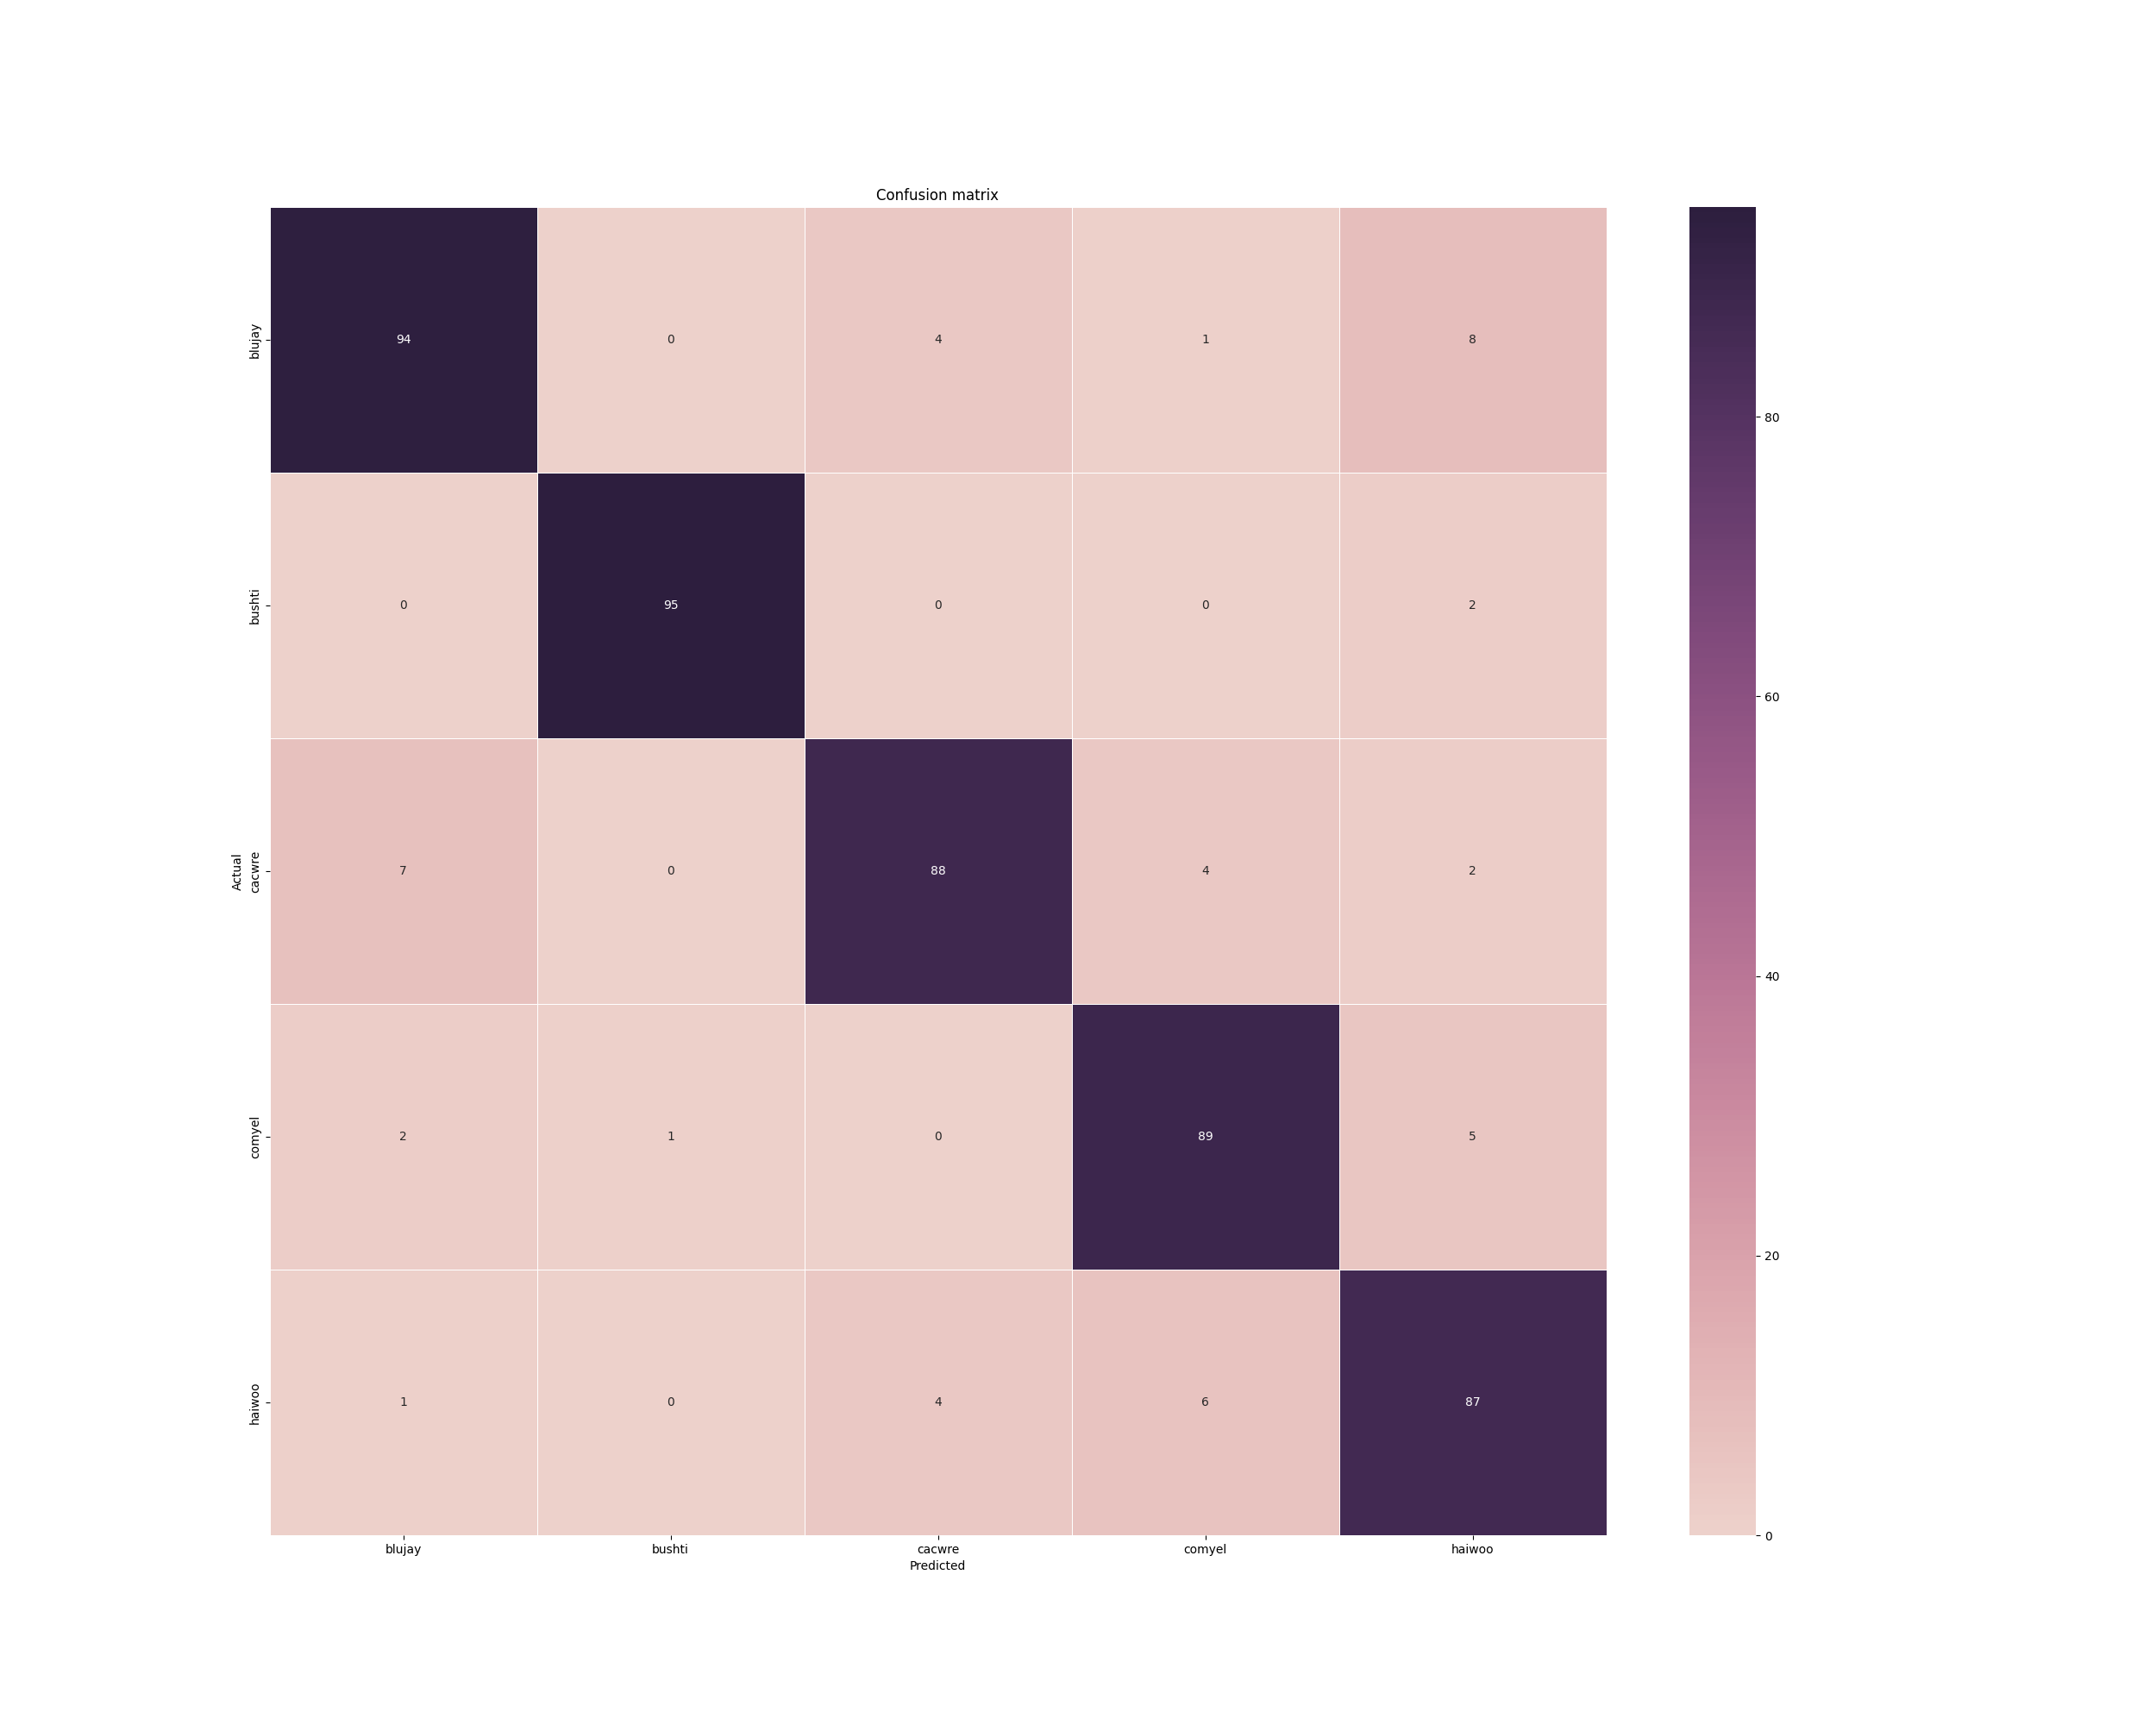

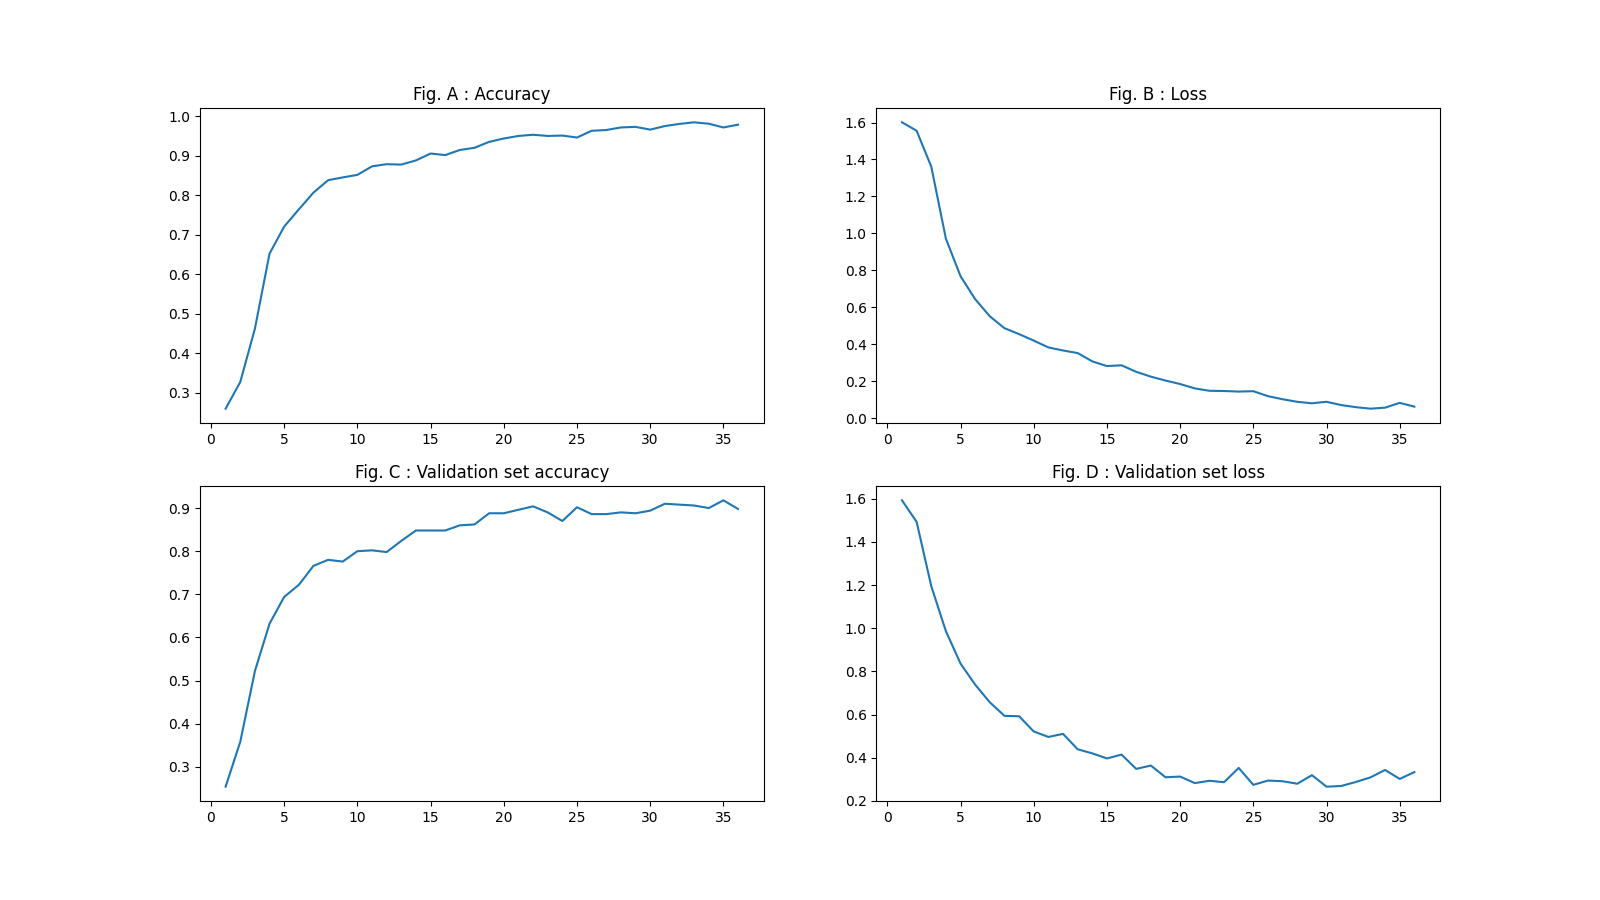

In [4]:
metrics:list = ["models_samples/model_01/cluster_matrix.png","models_samples/model_01/conf_matrix.png","models_samples/model_01/metrics.png"]

for metric in metrics:
    display(Image(filename=metric))

On va créer un ensemble de spectrogrammes "inconnus" à partir de l'espèce 'bushti'.

In [10]:
audio_folder:str = "toy_unknown"
output:str = "predict"

for specie in listdir(audio_folder):
    Path(f"{output}/{specie}").mkdir(parents=True, exist_ok=True)
    audio_processing(audio_folder,output,specie)

system(f"mv {output}/{specie}/* {output}/")
system(f"rm -r {output}/{specie}/")

CRITICAL:root:Processing specie 'toy_prediction'
C:\Users\Tharos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


0

On va exécuter les prédictions sur les spectrogrammes que l'on vient de générer avec le modèle d'exemple.

In [16]:
for img in listdir(output):
    print(sorted(prediction(f"{output}/{img}",trained_model,HEIGHT,WIDTH,classes),key=lambda x:x[1])[::-1])

1/1 [==============================] - 0s 39ms/step
[('American Bushtit', 40.46096205711365), ('Blue Jay', 14.884759485721588), ('Hairy Woodpecker', 14.884757995605469), ('Common Yellowthroat', 14.884757995605469), ('Cactus Wren', 14.884757995605469)]
1/1 [==============================] - 0s 36ms/step
[('American Bushtit', 40.460970997810364), ('Hairy Woodpecker', 14.884759485721588), ('Common Yellowthroat', 14.884759485721588), ('Cactus Wren', 14.884759485721588), ('Blue Jay', 14.884759485721588)]
1/1 [==============================] - 0s 35ms/step
[('American Bushtit', 40.460970997810364), ('Hairy Woodpecker', 14.884759485721588), ('Common Yellowthroat', 14.884759485721588), ('Cactus Wren', 14.884759485721588), ('Blue Jay', 14.884759485721588)]
1/1 [==============================] - 0s 38ms/step
[('American Bushtit', 40.460970997810364), ('Hairy Woodpecker', 14.884759485721588), ('Common Yellowthroat', 14.884759485721588), ('Cactus Wren', 14.884759485721588), ('Blue Jay', 14.8847594